In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
exclude_columns = ["time_stamp", "asset_id", "id"]


def load_df_and_annotate_anomalies(farm, event_id):
    path = f"../../../data/care_to_compare/Wind Farm {farm}/datasets/{event_id}.csv"
    df = pd.read_csv(path, delimiter=';')

    event_info = pd.read_csv(f"../../../data/care_to_compare/Wind Farm {farm}/event_info.csv", delimiter=';')

    # Find the row where event_id = event_id
    metadata = event_info[event_info['event_id'] == event_id]

    event_label = metadata["event_label"].values[0]
    event_start_id = metadata["event_start_id"].values[0]
    event_end_id = metadata["event_end_id"].values[0]

    label_value = 1 if event_label == "anomaly" else 0

    # All rows where the column "id" is between event_start_id and event_end_id
    df['label'] = 0
    df.loc[(df['id'] >= event_start_id) & (df['id'] <= event_end_id), 'label'] = label_value

    # Include all columns except for the ones in exclude_columns
    df = df[[col for col in df.columns if col not in exclude_columns]]

    # Remove columns with suffixes in exclude_columns_with_suffix
    #df = df[[col for col in df.columns if not col.endswith('_max')]]
    #df = df[[col for col in df.columns if not col.endswith('_min')]]
    #df = df[[col for col in df.columns if not col.endswith('_std')]]

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

In [101]:
def normalize_data(df, minmax, bits_per_column):
    normalized_df = df.copy()

    for col in df.columns:
        min_val = minmax[col][0]
        max_val = minmax[col][1]

        # Edge case where all values are 0
        if min_val == max_val:
            normalized_df[col] = 0
        else:
            normalized_df[col] = ((df[col] - min_val) / (max_val - min_val) * (
                    (2 ** bits_per_column) - 1))

    # Convert the normalized values to integers
    int_df = normalized_df.astype(int)

    return int_df

In [102]:
def calculate_min_max(farm, dataset_ids):
    # For each column get the min and max value
    min_max_values = {}

    for dataset_id in dataset_ids:
        df = load_df_and_annotate_anomalies(farm, dataset_id)

        for col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()

            if col not in min_max_values:
                min_max_values[col] = (min_val, max_val)
            else:
                current_min, current_max = min_max_values[col]
                min_max_values[col] = (min(min_val, current_min), max(max_val, current_max))

    return min_max_values

In [103]:
include_features = ["reactive_power_11", "sensor_12"]


def load_sensors(farm, datasets, minmax, bits_per_column=8):
    features = pd.read_csv(f"../../../data/care_to_compare/Wind Farm {farm}/feature_description.csv", delimiter=';')

    res = {}

    for dataset in datasets:
        df = load_df_and_annotate_anomalies(farm, dataset)

        df_normal = df[df['label'] == 0]

        df_anomaly = df[df['label'] == 1]
        df_idle = df_normal[df_normal['status_type_id'] == 2]
        df_normal_op = df_normal[df_normal['status_type_id'] == 0]
        df_failure = df_normal[df_normal['status_type_id'].isin([1, 3, 4, 5])]

        df_anomaly = df_anomaly.drop(columns=['label', 'train_test', 'status_type_id'])
        df_idle = df_idle.drop(columns=['label', 'train_test', 'status_type_id'])
        df_normal_op = df_normal_op.drop(columns=['label', 'train_test', 'status_type_id'])
        df_failure = df_failure.drop(columns=['label', 'train_test', 'status_type_id'])

        df_anomaly = normalize_data(df_anomaly, minmax, bits_per_column)
        df_idle = normalize_data(df_idle, minmax, bits_per_column)
        df_normal_op = normalize_data(df_normal_op, minmax, bits_per_column)
        df_failure = normalize_data(df_failure, minmax, bits_per_column)

        # Loop through all features (with index)
        for i, feature in features.iterrows():
            sensor_name = feature['sensor_name']
            statistic_types = ["avg", "min", "max", "std"]

            if sensor_name not in include_features:
                continue

            for statistic_type in statistic_types:
                feature_name = f"{sensor_name}_{statistic_type}"

                # Get the column that represents the feature
                df_anomaly_feature = df_anomaly[[feature_name]]
                df_idle_feature = df_idle[[feature_name]]
                df_normal_op_feature = df_normal_op[[feature_name]]
                df_failure_feature = df_failure[[feature_name]]

                # Group the data in n bins
                anomaly_count, anomaly_bin_edges = np.histogram(df_anomaly_feature, bins=2 ** bits_per_column)
                idle_count, idle_bin_edges = np.histogram(df_idle_feature, bins=2 ** bits_per_column)
                normal_op_count, normal_op_bin_edges = np.histogram(df_normal_op_feature, bins=2 ** bits_per_column)
                failure_count, failure_bin_edges = np.histogram(df_failure_feature, bins=2 ** bits_per_column)

                # Increment the counts for the feature for each bin
                if feature_name not in res:
                    res[feature_name] = {"anomaly_count": anomaly_count, "idle_count": idle_count,
                                         "normal_op_count": normal_op_count, "failure_count": failure_count,
                                         "feature": feature, "statistic_type": statistic_type}
                else:
                    res[feature_name]["anomaly_count"] += anomaly_count
                    res[feature_name]["idle_count"] += idle_count
                    res[feature_name]["normal_op_count"] += normal_op_count
                    res[feature_name]["failure_count"] += failure_count

    return res


In [104]:
def plot_results(results: dict, plot_title):
    num_plots = len(results)  # Total number of plots
    num_cols = 3  # Fixed width (number of columns)
    num_rows = -(-num_plots // num_cols)  # Compute required rows (ceiling division)

    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 4))
    #plt.subplots_adjust(wspace=0.9, hspace=0.9)

    items = results.items()

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i, (feature, data) in enumerate(items):
        ax = axes[i]

        # Get the counts and the feature
        anomaly_count = data["anomaly_count"]
        idle_count = data["idle_count"]
        normal_op_count = data["normal_op_count"]
        failure_count = data["failure_count"]

        feature = data["feature"]

        # X positions for bars (assuming sequential bins)
        bins = np.arange(len(anomaly_count))

        # Plot histogram using a bar chart

        ax.bar(bins - 0.3, anomaly_count, width=0.8, label="Anomaly", color="#bf616a")
        ax.bar(bins - 0.2, idle_count, width=0.8, label="Idle", color="#8fbcbb")
        ax.bar(bins - 0.1, normal_op_count, width=0.8, label="Normal", color="#81a1c1")
        ax.bar(bins - 0.0, failure_count, width=0.8, label="Failure", color="#ebcb8b")

        # Add a title for the subplot
        ax.set_title(
            f"{feature["description"]}\n{feature["sensor_name"]} {data["statistic_type"]} ({feature["unit"]})")

        # Add a subtitle for the subplot
        ax.set_xlabel("Bin")
        ax.set_ylabel("Count")

        # Disable x axis labels
        ax.set_xticks([])
        ax.legend()

    fig.suptitle(f"Min-Max binarized value distribution for selected sensors\nWind farm B and b=5", fontsize=16,
                 fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.show()

    # Save the figure

    fig.savefig(f"{plot_title}.pdf")


In [105]:
datasets = [2, 7, 19, 21, 23, 27, 34, 52, 53, 74, 77, 82, 83, 86, 87]

min_max_values = calculate_min_max("B", datasets)

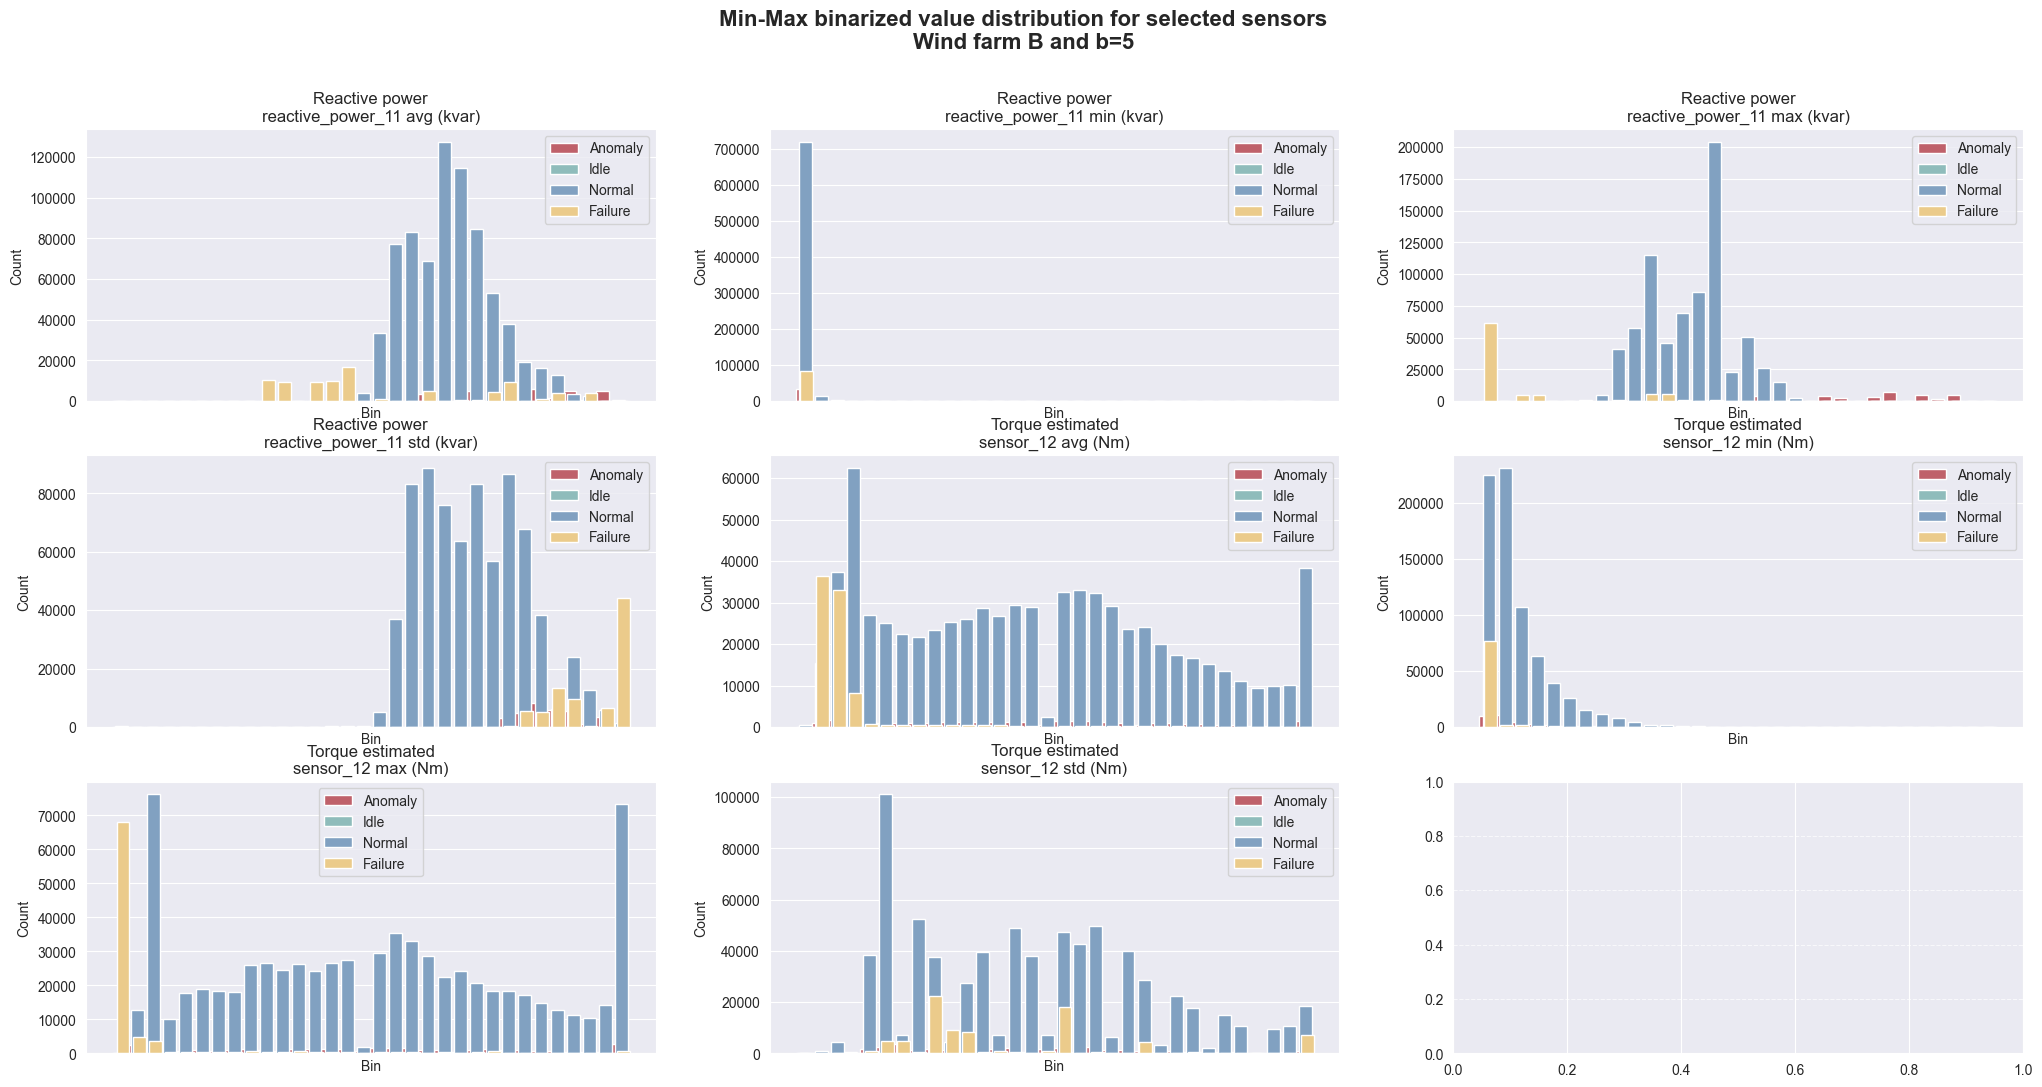

In [106]:
bits = 5
results = load_sensors("B", datasets, min_max_values, bits_per_column=bits)
plot_results(results, f"sensor_histograms_minmax_{bits}_bit")